
# Lab4: Closed-loop Control


All the previous labs are preparatory for this lab: controller design. Given a dynamic system, how can we design a controller to make it stable (such as make a drone hover in air), track a desired trajectory (make a robotic arm follow a line for welding), etc.? In this lab, we will practice how to design controllers based on state-space models for mechanical systems. You will learn how to analyze their controllability, connect the controller and the dynamics of the systems, and design controllers that achieve desired closed-loop performance. Through hands-on exercises, you will use the Python Control Systems Library to:

- Model both linear and nonlinear systems
- Test system controllability
- Design state-feedback controllers using eigenvalue assignment techniques
- Compute feedforward gains to enable accurate reference tracking
- Simulate and visualize the time response of both open-loop and closed-loop systems

By the end of this lab, you will gain practical experience in applying modern control design methods to real-world mechanical systems using Python.

## Setup (run once per environment)
We first need to install `python-control` (and import required libraries) **every time you open this notebook**, to ensure all dependencies are available in your current environment.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Import the python-control package
try:
    import control as ctl # ctl is the alias for control
    print("python-control", ctl.__version__)
except ImportError:
    %pip install control
    import control as ctl

%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True

python-control 0.10.2


## Task 1 — Conroller Design for Coupled Mass Spring System

In this task, we will design a controller for the coupled mass-spring system using the Python Control Systems Library.

<center><img src="https://www.cds.caltech.edu/~murray/courses/cds110/sp2024/springmass-coupled.png" width=640></center>


### System dynamics

For completeless, we include the dynamics of the system again here

$$
\begin{aligned}
  m \ddot{q}_1 &= -2 k q_1 - c \dot{q}_1 + k q_2, \\
  m \ddot{q}_2 &= k q_1 - 2 k q_2 - c \dot{q}_2 + ku
\end{aligned}
$$

or in state space form, with state vector $x = [x_1,\, x_2,\, x_3,\, x_4]^T$ where
- $x_1 = q_1$ (position of mass 1)
- $x_2 = q_2$ (position of mass 2)
- $x_3 = \dot{q}_1$ (velocity of mass 1)
- $x_4 = \dot{q}_2$ (velocity of mass 2)
  
For output, we consider we are only interested in the position of mass one for now. In this case, we have output of $y= q_1$

$$
\begin{aligned}
    \dfrac{dx}{dt} &= \begin{bmatrix}
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1 \\[0.5ex]
        -\dfrac{2k}{m} & \dfrac{k}{m} & -\dfrac{c}{m} & 0 \\[0.5ex]
        \dfrac{k}{m} & -\dfrac{2k}{m} & 0 & -\dfrac{c}{m}
    \end{bmatrix} x
    + \begin{bmatrix}
        0 \\ 0 \\[0.5ex] 0 \\[1ex] \dfrac{k}{m}
    \end{bmatrix} u, \\[2ex]
    y &= \begin{bmatrix}
        1 & 0 & 0 & 0
    \end{bmatrix} x
\end{aligned}
$$

In [28]:
# Define the parameters for the system
m, c, k = 1, 0.1, 2
# Create a linear system
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [-2*k/m, k/m, -c/m, 0],
    [k/m, -2*k/m, 0, -c/m]
])
B = np.array([[0], [0], [0], [k/m]])
C = np.array([1, 0, 0, 0])
D = 0

# Create a state-space system using A, B, C, D
# https://python-control.readthedocs.io/en/0.10.2/generated/control.ss.html
sys = ctl.ss(A, B, C, D, outputs=['q1'], name="coupled spring mass")
print(sys)

<StateSpace>: coupled spring mass
Inputs (1): ['u[0]']
Outputs (1): ['q1']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.   0.   1.   0. ]
     [ 0.   0.   0.   1. ]
     [-4.   2.  -0.1  0. ]
     [ 2.  -4.   0.  -0.1]]

B = [[0.]
     [0.]
     [0.]
     [2.]]

C = [[1. 0. 0. 0.]]

D = [[0.]]


### Controllability Testing

In [30]:
# Compute the controllability matrix and its rank and determinant
ctrb = ctl.ctrb(A, B)
rank = np.linalg.matrix_rank(ctrb)
determinant = np.linalg.det(ctrb)

print(f"Controllability matrix:\n{ctrb}")
print(f"Determinant: {determinant} (nonzero means full rank)")
print(f"Rank: {rank} (should be {A.shape[0]} for controllable system)")

Controllability matrix:
[[ 0.     0.     0.     4.   ]
 [ 0.     2.    -0.2   -7.98 ]
 [ 0.     0.     4.    -0.8  ]
 [ 2.    -0.2   -7.98   1.598]]
Determinant: -63.99999999999998 (nonzero means full rank)
Rank: 4 (should be 4 for controllable system)


### Controller Design
Now we can design a state-feedback controller to make the output $y$ track a desired value $r$.
$$
u=-Kx+K_fr
$$

In [33]:
# We assume the following desired closed-loop poles (eigenvalues)
desired_eigenvalues = [-2, -2.5, -3, -3.5]  # original choice
# Alternative choices:
# desired_eigenvalues = [-2 + 1j, -2 - 1j, -3 + 2j, -3 - 2j]

# Place the poles using state feedback (assuming full state feedback)
K = ctl.place(A, B, desired_eigenvalues)
print("State feedback gain K:", K)

# Compute feedforward gain for reference tracking (for output y = q1)
A_cl = A - B @ K
Kf =  (-1 / (C @ np.linalg.inv(A_cl) @ B))
print('Kf: '+str(Kf))


State feedback gain K: [[-25.535  17.83    8.046   5.4  ]]
Kf: [13.125]


### Simulate the closed-loop system

Now that we have our gains designed, we can simulate the closed loop system:
$$
\begin{align}
\frac{dx}{dt} &= Ax + Bu \\
              & = Ax + B(-Kx+k_fr)\\
              & =(A-BK)x+Bk_fr \\
              & =  A_{cl}x + B_{cl} r,
\end{align}
$$
where $A_{cl} = A-BK$, $B_{cl} = Bk_f$. Notice that, with a state feedback controller, the new (closed loop) dynamics matrix $A_{cl}$ absorbs the old (open loop) "input" $u$, and the new (closed loop) input is our reference signal $r$. This is shown in the following figure.

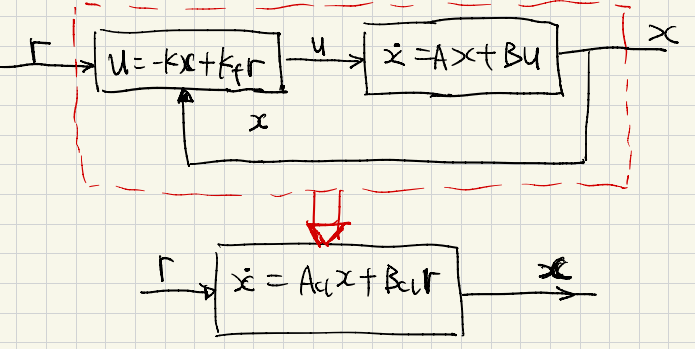

In [34]:
# Create a closed loop system
A_cl = A - B @ K
B_cl =  B * Kf
clsys = ctl.ss(A_cl, B_cl, C, 0)
print(clsys)

<StateSpace>: sys[8]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[  0.      0.      1.      0.   ]
     [  0.      0.      0.      1.   ]
     [ -4.      2.     -0.1     0.   ]
     [ 53.07  -39.66  -16.092 -10.9  ]]

B = [[ 0.  ]
     [ 0.  ]
     [ 0.  ]
     [26.25]]

C = [[1. 0. 0. 0.]]

D = [[0.]]


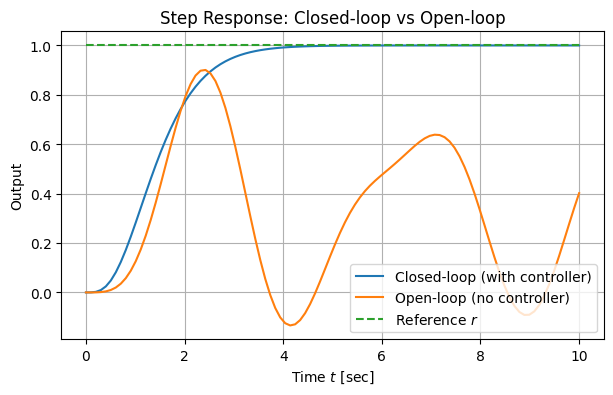

In [35]:
# Plot the step response with and without the controller
tvec = np.linspace(0, 10, 100)
U = 1  # Step input magnitude
r = 1  # Reference value

# Closed-loop response (with controller)
time_op, output_op = ctl.input_output_response(clsys, tvec, U)

# Open-loop response (no controller)
time_ol, output_ol = ctl.input_output_response(sys, tvec, U)

plt.plot(time_op, output_op, label='Closed-loop (with controller)')
plt.plot(time_ol, output_ol, label='Open-loop (no controller)')
plt.plot([time_op[0], time_op[-1]], [r, r], '--', label='Reference $r$')
plt.legend()
plt.ylabel("Output")
plt.xlabel("Time $t$ [sec]")
plt.title("Step Response: Closed-loop vs Open-loop")
plt.show()

## Task 2 — Conroller Design for Pendulum System

In this task, we will design controllers for the pendulum system. For completeness, we include the dynamics equation here again:

$$
\begin{align}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= -\frac{g}{L}\sin x_1 - \frac{b}{mL^2}\,x_2 + \frac{u}{mL^2}
\end{align}
$$

where:
- $x_1 = \theta$ (angle)
- $x_2 = \dot{\theta}$ (angular velocity)
- $g = 9.81\,\text{m/s}^2$
- $m = 1 \,\text{kg}$
- $L = 1\,\text{m}$
- $b = 1.5$ (N.m.s/rad, damping coefficient)

We begin by creating a nonlinear model of the system:

In [36]:
# Parameter values for pendulum
pendulum_params = {
    'g': 9.81,            # Gravitational acceleration (m/s^2)
    'L': 1.0,             # Pendulum length (m)
    'b': 0.5,             # Damping coefficient (N.m.s/rad)
    'm': 1.0,             # Pendulum mass (kg)
}

# State derivative for pendulum
def pendulum_update(t, x, u, params):
    # Extract the configuration and velocity variables from the state vector
    theta = x[0]                # Angular position of the pendulum
    thetadot = x[1]             # Angular velocity of the pendulum
    tau = u[0]                  # Torque applied at the pivot

    # Get the parameter values
    g, L, b, m = map(params.get, ['g', 'L', 'b', 'm'])

    # Compute the angular acceleration using pendulum dynamics
    # x_dot_1 = x_2
    # x_dot_2 = -g/L * sin(x_1) - b/(m*L^2) * x_2 + u/(m*L^2)
    dthetadot = -g/L * np.sin(theta) - b/(m*L**2) * thetadot + tau/(m*L**2)

    # Return the state update law
    return np.array([thetadot, dthetadot])

# System output (angle only, as specified y = x_1)
def pendulum_output(t, x, u, params):
    return np.array([x[0]])  # Output y = theta (x_1)

# create the nonlinear system using nlsys,
# note that the outputs is theta so that we can successfully connect the controller to it
pendulum = ctl.nlsys(
    pendulum_update, pendulum_output, name='pendulum',
    params=pendulum_params, states=['theta', 'thetadot'],
    outputs=['theta'], inputs=['tau'])

print(pendulum)
print("\nParams:", pendulum.params)

<NonlinearIOSystem>: pendulum
Inputs (1): ['tau']
Outputs (1): ['theta']
States (2): ['theta', 'thetadot']
Parameters: ['g', 'L', 'b', 'm']

Update: <function pendulum_update at 0x7d1e3c981bc0>
Output: <function pendulum_output at 0x7d1e3c980ae0>

Params: {'g': 9.81, 'L': 1.0, 'b': 0.5, 'm': 1.0}


### Proportional feedback controller

We first try to stabilize the system at $\theta_d=\pi$ using a simple proportional feedback controller:

$$u = -k_\text{p} (\theta-\pi).$$

This controller can be designed as an input/output system that has no state dynamics, just a mapping from the inputs to the outputs.

**Inputs and outputs for each block that we will create:**

- **Controller**
    - *Inputs*: $\theta$ (measured angle from pendulum), $r$ (reference/desired angle)
    - *Output*: $\tau$ (control torque to be applied to the pendulum)

- **Pendulum dynamics**
    - *Input*: $\tau$ (control torque from controller)
    - *Outputs*: $\theta$ (pendulum angle), $\dot{\theta}$ (angular velocity)

- **Closed-loop system**
    - *Input*: $r$ (reference/desired angle)
    - *Output*: $\theta$ (pendulum angle)

This separation of roles allows us to connect the controller and the plant (pendulum) in a feedback loop, where the controller processes the measured output and reference to generate the appropriate input for the plant.

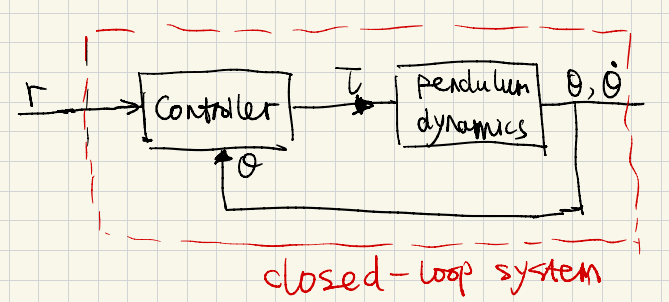

In [37]:
# Set up the controller
def propctrl_output(t, x, u, params):
  kp = params.get('kp', 1)
  return -kp * (u[0] - u[1]) # u[0] is theta, u[1] is r, which is the desired angle

# Create the proportional controller as a nonlinear system
propctrl = ctl.nlsys(
    None, propctrl_output, name="p_ctrl",
    inputs=['theta', 'r'], outputs='tau'
)
print(propctrl)

<NonlinearIOSystem>: p_ctrl
Inputs (2): ['theta', 'r']
Outputs (1): ['tau']
States (0): []

Update: <function NonlinearIOSystem.__init__.<locals>.<lambda> at 0x7d1e3c9c51c0>
Output: <function propctrl_output at 0x7d1e3c9c53a0>


To connect the controller to the system, we use the [`interconnect`](https://python-control.readthedocs.io/en/latest/generated/control.interconnect.html) function, which will connect all signals that have the same names:

In [38]:
# Create the closed loop system
clsys = ctl.interconnect(
    [pendulum, propctrl], name='pendulum w/ proportional feedback',
    inputs=['r'], outputs=['theta'], params={'kp'})
print(clsys)

<InterconnectedSystem>: pendulum w/ proportional feedback
Inputs (1): ['r']
Outputs (1): ['theta']
States (2): ['pendulum_theta', 'pendulum_thetadot']

Subsystems (2):
 * <NonlinearIOSystem pendulum: ['tau'] -> ['theta']>
 * <NonlinearIOSystem p_ctrl: ['theta', 'r'] -> ['tau']>

Connections:
 * pendulum.tau <- p_ctrl.tau
 * p_ctrl.theta <- pendulum.theta
 * p_ctrl.r <- r

Outputs:
 * theta <- pendulum.theta


We can now linearize the closed loop system at different values of $k_p$ and compute the eigenvalues to check for stability:

In [ ]:
for kp in [0, 1, 10]:
    lin_sys = clsys.linearize([np.pi, 0], [0], params={'kp': kp})
    A = lin_sys.A
    eigvals = np.linalg.eigvals(A)
    print(f"kp = {kp}; A =\n{A}\neigenvalues = {eigvals}\n")

kp = 0; A =
[[ 0.    1.  ]
 [ 9.81 -0.5 ]]
eigenvalues = [ 2.89205347 -3.39205347]

kp = 1; A =
[[ 0.    1.  ]
 [ 8.81 -0.5 ]]
eigenvalues = [ 2.7286742 -3.2286742]

kp = 10; A =
[[ 0.    1.  ]
 [-0.19 -0.5 ]]
eigenvalues = [-0.25+0.35707142j -0.25-0.35707142j]



Now we can simulate the closed-loop system (with proportional control) and open-loop (no control)


<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-997698303.py:17: SyntaxWarning: invalid escape sequence '\p'
  plt.axhline(np.pi, color='gray', linestyle='--', label='Reference ($\pi$)')


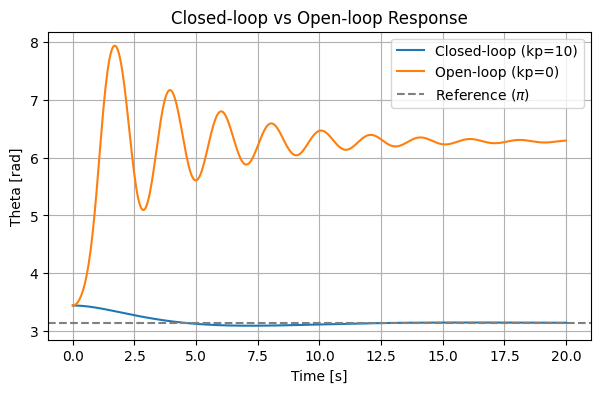

In [39]:
timepts = np.linspace(0, 20, 500)
x0 = [np.pi + 0.3, 0]  # initial condition: slightly perturbed from upright

# Closed-loop: kp = 10
# U=np.full_like(timepts, np.pi) creates the reference input signal for the simulation.
Cl_response = ctl.input_output_response(
    clsys, timepts, U=np.full_like(timepts, np.pi), X0=x0, params={'kp': 10}, return_x=True
)

# Open-loop: kp = 0
Ol_response = ctl.input_output_response(
    clsys, timepts, U=np.full_like(timepts, np.pi), X0=x0, params={'kp': 0}, return_x=True
)

plt.plot(timepts, Cl_response.outputs, label='Closed-loop (kp=10)')
plt.plot(timepts, Ol_response.outputs, label='Open-loop (kp=0)')
plt.axhline(np.pi, color='gray', linestyle='--', label='Reference ($\pi$)')
plt.xlabel('Time [s]')
plt.ylabel('Theta [rad]')
plt.title('Closed-loop vs Open-loop Response')
plt.legend()
plt.show()

### State space controller

For the proportional controller, we have limited control over the dynamics of the closed loop system.  An alternative is to use "full state feedback" for reference tracking, in which we set

$$
\tilde{u} = u-u_d= -K\tilde{x} + K_f \tilde{r} = -k_1 (\theta -\theta_d) - k_2 (\dot\theta -\dot\theta_d) + K_f (r - \theta_d)
$$

where $K = [k_1, k_2]$ is the feedback gain and $K_f$ is the feedforward gain for tracking the reference $r = \theta_d$. Note that we use $\tilde{u}$ and $\tilde{x}$ here to indicate we linearize the system at an operating point.

We have verified in class the linearized system around $\theta_d=\pi$ is controllable.  

In [40]:
# Linearize the original pendulum system around theta = pi, thetadot = 0, tau = 0
P = pendulum.linearize([np.pi, 0], [0])
ctrb_matrix = ctl.ctrb(P.A, P.B) # Controllability matrix
rank = np.linalg.matrix_rank(ctrb_matrix)
determinant = np.linalg.det(ctrb_matrix)

print(f"Determinant: {determinant} (nonzero means full rank)")
print(f"Controllability matrix:\n{ctrb_matrix}")
print(f"Rank: {rank} (should be {P.A.shape[0]} for controllable system)")

Determinant: -1.0 (nonzero means full rank)
Controllability matrix:
[[ 0.   1. ]
 [ 1.  -0.5]]
Rank: 2 (should be 2 for controllable system)


To compute the gains $K$, we make use of the `place` command, applied to the linearized system:

In [44]:
# Place the closed loop eigenvalues (poles) at desired locations
# Assume the desired poles are at -1 +/- 0.1j
K = ctl.place(P.A, P.B, [-1 + 0.1j, -1 - 0.1j])
#K = ctl.place(P.A, P.B, [-2, -1.0])
print(f"Feedback gain K = {K}")

# Compute feedforward gain for reference tracking
# For pendulum, C = [1, 0] to extract theta from state
C = np.array([[1, 0]])  # Output matrix for theta
A_cl = P.A - P.B @ K    # Closed-loop A matrix
Kf = -1 / (C @ np.linalg.inv(A_cl) @ P.B)[0, 0]  # [0, 0] extracts the single element from this 1×1 matrix

print(f"Feedforward gain Kf = {Kf}")

Feedback gain K = [[10.82  1.5 ]]
Feedforward gain Kf = 1.0099999999999998


Now we can obtain the controller

In [45]:
def statefbk_output(t, x, u, params):
  K = params.get('K', np.array([0, 0]))
  Kf = params.get('Kf', 0)

  # Current state from pendulum
  x_current = u[0:2]  # [theta, thetadot]
  r = u[2]            # Reference input (desired theta)

  # operating point where we linearized
  x_d = np.array([np.pi, 0])  # [theta_eq, thetadot_eq]


  # Controller: \tilde{u} = -K*\tilde{x} + Kf * \tilde{r}
  # we need to switch to the original
  return -K @ (x_current - x_d) + Kf * (r - np.pi)

# Create the state feedback controller as a nonlinear system
statefbk = ctl.nlsys(
  None, statefbk_output, name="k_ctrl",
  inputs=['theta', 'thetadot', 'r'], outputs='tau'
)
print(statefbk)

<NonlinearIOSystem>: k_ctrl
Inputs (3): ['theta', 'thetadot', 'r']
Outputs (1): ['tau']
States (0): []

Update: <function NonlinearIOSystem.__init__.<locals>.<lambda> at 0x7d1e3c789080>
Output: <function statefbk_output at 0x7d1e3c7885e0>


After defining the state-feedback controller, we can connect it to the pendulum system to create a closed-loop system.

In [46]:
clsys_sf = ctl.interconnect(
    [pendulum, statefbk], name='pendulum w/ state feedback',
    inputs=['r'], outputs=['theta'], params={'K': K, 'Kf': Kf})
print(clsys_sf)

<InterconnectedSystem>: pendulum w/ state feedback
Inputs (1): ['r']
Outputs (1): ['theta']
States (2): ['pendulum_theta', 'pendulum_thetadot']

Subsystems (2):
 * <NonlinearIOSystem pendulum: ['tau'] -> ['theta']>
 * <NonlinearIOSystem k_ctrl: ['theta', 'thetadot', 'r'] -> ['tau']>

Connections:
 * pendulum.tau <- k_ctrl.tau
 * k_ctrl.theta <- pendulum.theta
 * k_ctrl.thetadot <-
 * k_ctrl.r <- r

Outputs:
 * theta <- pendulum.theta


Now we can see how the designed state-feedback controller will influence the system. We can visulize this through the same response.

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-343988928.py:15: SyntaxWarning: invalid escape sequence '\p'
  plt.axhline(np.pi, color='gray', linestyle='--', label='Reference ($\pi$)')


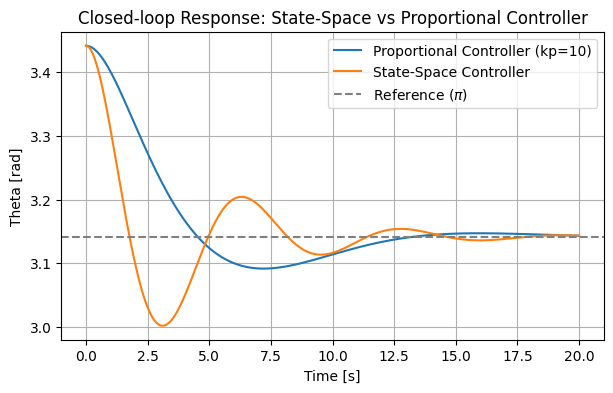

In [47]:
# Compare the performance of state-space controller vs proportional controller

# Simulate state-space controller (closed-loop)
sf_response = ctl.input_output_response(
    clsys_sf, timepts, U=np.full_like(timepts, np.pi), X0=x0, return_x=True
)

# Simulate proportional controller (closed-loop)
p_response = ctl.input_output_response(
    clsys, timepts, U=np.full_like(timepts, np.pi), X0=x0, params={'kp': 10}, return_x=True
)

plt.plot(timepts, p_response.outputs, label='Proportional Controller (kp=10)')
plt.plot(timepts, sf_response.outputs, label='State-Space Controller')
plt.axhline(np.pi, color='gray', linestyle='--', label='Reference ($\pi$)')
plt.xlabel('Time [s]')
plt.ylabel('Theta [rad]')
plt.title('Closed-loop Response: State-Space vs Proportional Controller')
plt.legend()
plt.show()

### Things to try

Here are some things to try with the above code:
* Try changing the locations of the closed loop eigenvalues in the `place` command to make the repose better than the proportional controller.
* Try leaving the state space controller fixed but changing the parameters of the system dynamics ($m$, $l$, $b$).  Does the controller still stabilize the system?

# HW problems

## Problem 1: Servo Mechanism State-Feedback Control
Consider the same servo mechanism again. The equations of motion for the system are given by
$$
J \ddot \theta = -b \dot\theta - k r\sin\theta + \tau_\text{m},
$$
where
- $J$ is the rotational inertia of the arm (kg·m²)
- $b$ is the viscous damping coefficient (N·m·s/rad)
- $k$ is the linear spring constant (N/m)
- $r$ is the effective radius or lever arm where the spring force acts (m)

Define the state vector $x = [\theta,\, \dot{\theta}]^T$ and output $y = \theta$. The dynamics can be written in state-space form: $\dot{x} = f(x, u)$, $y = g(x, u)$ with $u=\tau_\text{m}$ as

$$
\begin{align*}
\dot{x} &= \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix}  =
  \begin{bmatrix} x_2 \\ -k r \sin x_1 / J - bx_2 / J + u/J \end{bmatrix} \\
  y &= x_1
\end{align*}
$$

$$ k = 1,\quad J = 100,\quad b = 10,
    \quad r = 1
$$
   
In the previous lab, we have linearized the system around $y_d=75^\circ$ to obtain $A$, $B$, $C$, $D$ matrices. Now we will practice controller design and analysis for the linearized system, similar to the tasks in this lab.

1. **Programming problem:** Check the controllability of the linearized system using the controllability matrix and its rank.

2. **Programming problem:** Design a state-feedback controller to track the desired position $y_\text{d}=75^\circ$ by placing the closed-loop eigenvalues at $\lambda_{1,2} = -10 \pm 10i$. Compute the state feedback gain $K$ and the feedforward gain $K_f$ for reference tracking.

3. **Programming problem:** Simulate and plot the response of the closed-loop system when $\theta$ starts at two different initial angles $70^\circ$ and $50^\circ$. Compare the closed-loop response to the open-loop response (i.e., no control is applied).




## Problem 2: Cart–Pole State Feedback Control

For this problem, we will consider the cart–pole system. The equations of motion for the system are given by

$$
\ddot{x} = \frac{1}{m_c + m_p \sin^2\theta}
\left[f_x + m_p \sin\theta\big(l\dot{\theta}^2 + g\cos\theta\big)\right]
$$

$$
\ddot{\theta} = \frac{1}{l(m_c + m_p \sin^2\theta)}
\left[-f_x\cos\theta - m_p l\dot{\theta}^2\cos\theta\sin\theta
- (m_c+m_p)g\sin\theta\right]
$$

where  

- $x$: cart position  
- $\theta$: pole angle measured from vertical (counter-clockwise positive)  
- $g$: gravitational constant  
- $f_x$: horizontal force input to the cart  

Define the state vector, output, and control input as  

$$
\mathbf{x} = [\,x,\, \dot{x},\, \theta,\, \dot{\theta}\,]^T,
\quad y = \theta,
\quad u = f_x
$$

so the dynamics can be written as $\dot{x} = f(x, u),\; y = g(x, u)$.

Use the following parameters:

$$
m_c = 1.0,\quad m_p = 0.1,\quad l = 0.5,\quad g = 9.81
$$

Last Lab we have linearized the system around the upward equilibrium $\theta_d = \pi$ to get the $A, B, C, D$ matrices.

1. **Programming Problem:** Check the controllability of the linearized system using the controllability matrix and its rank.

2. **Programming Problem:** Design a state-feedback controller to stabilize the pendulum at $\theta_d = \pi$ by placing the closed-loop eigenvalues at the following locations:
   - $\lambda_{1,2} = -1 \pm 2i$, $\lambda_{3,4} = -0.35 \pm 0.35i$
   - $\lambda_{1,2} = -0.33 \pm 0.66i$, $\lambda_{3,4} = -0.18 \pm 0.18i$

   Compute the state feedback gain $K$ and the feedforward gain $K_f$ for reference tracking.

3. **Programming Problem:** Simulate and plot the response of the closed-loop system when the pendulum starts at $\theta = 0.9\pi$. Compare the closed-loop response to the open-loop response (i.e., no control is applied).

